# 為替レートとPPP

In [1]:
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

## はじめに

通常，経済の生活水準の指標には一人当たりGDPが使われる。データはそれぞれの国が集めており，日本では[内閣府](https://www.esri.cao.go.jp/jp/sna/menu.html)がGDP関連の変数を公表している。当たり前だが，GDPなどの変数はその経済の貨幣単位で表される。自国通貨建ての変数は国内で使うには十分だが，他国と比較する場合は共通の貨幣で表す必要がある。例えば，日本と米国の生活水準や政府の教育関連支出額の違いを知るためには，両国の変数を円もしくは米ドルに返還する必要がある。また，変数の水準だけではなく成長率を考える際も同様である。

では，ある通貨を他の通貨単位に換算する際，新聞やインターネットで見る為替レートを使えば良いのだろうか。答えは「否」である。その理由を理解するのが本章の１つの目的となる。異なる経済の変数を比べる際は購買力平価（PPP; Purchasing Power Parity）と呼ばれる「為替レート」を使うことになる。実際，`py4macro`モジュールに含まれるデータセット`pwt`（Penn World Table）はPPPで換算したマクロ変数を使っている。

以下では、まず一物一価の法則について国内のデータを使い考え，その後，ビッグマックのデータを使い経済間での一物一価を考察する。これらの説明に基づき購買力平価の意味とそれを使う意義について考える。

## 国内での一物一価

### 全国統一価格品目

* 鉄道運賃(JR，通学定期旅客運賃(高校生)，JR西日本，幹線，20km) 6ヶ月　38,650円（2021年平均）

＜参考＞
○鉄道事業法（昭和６１年法律第９２号）
（旅客の運賃及び料金）
第十六条　鉄道運送事業者は、旅客の運賃及び国土交通省令で定める旅客の料金（以下「旅客運賃
　等」という。）の上限を定め、国土交通大臣の認可を受けなければならない。これを変更しよう
　とするときも、同様とする。
２　国土交通大臣は、前項の認可をしようとするときは、能率的な経営の下における適正な原価に
　適正な利潤を加えたものを超えないものであるかどうかを審査して、これをしなければならない。
３～５　（略）

このように法的に決められたものもある。市場で決定される場合の例として次の２つを挙げる。

### チョコレート

* 板チョコレート，50～55g，「明治ミルクチョコレート」，「ロッテガーナミルクチョコレート」又は「森永ミルクチョコレート」
* 2021年平均
* https://www.e-stat.go.jp/stat-search/files?page=1&query=チョコレート&layout=dataset&toukei=00200571&tstat=000000680001&stat_infid=000032193039&metadata=1&data=1
* https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200571&tstat=000000680001&cycle=7&year=20210&month=0
    * 「1701 ようかん」 ～ 「1797 弁当」

In [2]:
file_choco = '/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/b00109.xlsx'
choco = pd.read_excel(file_choco, sheet_name='1761チョコレート', 
                      skiprows=15, usecols=[8,10])
choco.head()
# choco.tail()

,地域,年平均
0,札幌市,203
1,函館市,198
2,旭川市,198
3,青森市,202
4,八戸市,208


In [3]:
choco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   地域      81 non-null     object
 1   年平均     81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [4]:
choco.columns = ['area', 'price']

In [5]:
choco['price'].describe()

count     81.000000
mean     205.790123
std        6.847839
min      174.000000
25%      203.000000
50%      206.000000
75%      210.000000
max      221.000000
Name: price, dtype: float64

最安値は174円，最高値は221円であり，その差は47円。

ここでは次の指標を使って価格の分布を考察する。

$$
価格の平均からの乖離率=\log(P_i)-\log\left(\overline{P}_i\right)
$$

ここで$i$は地域を表しており，$\overline{P}_i$は$P_i$の平均である。

In [6]:
choco['mean_deviation'] =  np.log( choco['price'] )- np.log( choco['price'].mean() )

<AxesSubplot:>

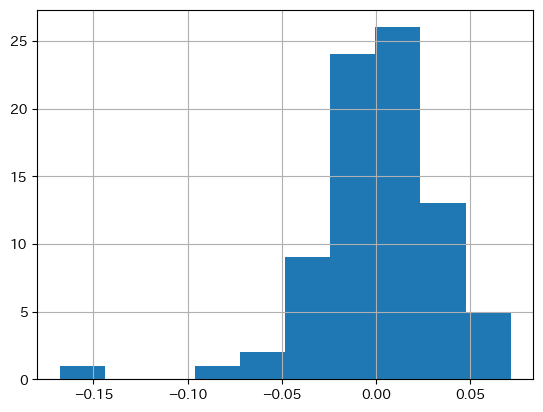

In [7]:
choco['mean_deviation'].hist()

In [8]:
cond = ( choco['price']==choco['price'].min() )
choco.loc[cond,:]

,area,price,mean_deviation
7,秋田市,174,-0.167802


価格のばらつき具合を確認するために標準偏差を計算しよう。

In [9]:
choco['mean_deviation'].std()

0.034029087481104274

### アイスクリーム

* バニラアイスクリーム，カップ入り（110mL入り），「ハーゲンダッツ バニラ」
* 2021年平均
* https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200571&tstat=000000680001&cycle=7&year=20210&month=0
    * 「1701 ようかん」 ～ 「1797 弁当」

In [10]:
file_ice = '/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/b00109.xlsx'
ice = pd.read_excel(file_ice, sheet_name='1782アイスクリーム', 
                      skiprows=15, usecols=[8,10])
ice.head()
# ice.tail()

,地域,年平均
0,札幌市,297
1,函館市,279
2,旭川市,282
3,青森市,261
4,八戸市,256


In [11]:
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   地域      81 non-null     object
 1   年平均     81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [12]:
ice.columns = ['area', 'price']

In [13]:
ice['price'].describe()

count     81.000000
mean     264.604938
std       17.950403
min      214.000000
25%      256.000000
50%      267.000000
75%      278.000000
max      305.000000
Name: price, dtype: float64

最安値は214円，最高値は305円であり，その差は91円。

In [14]:
ice['mean_deviation'] =  np.log( ice['price'] )- np.log( ice['price'].mean() )

<AxesSubplot:>

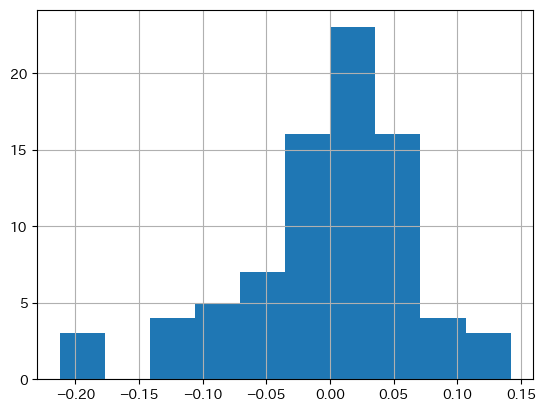

In [15]:
ice['mean_deviation'].hist()

In [16]:
cond = ( ice['price']==ice['price'].min() )
ice.loc[cond,:]

,area,price,mean_deviation
22,浦安市,214,-0.212262
37,長野市,214,-0.212262


寒い地域が安いわけではない

In [17]:
cond = ( ice['price']==ice['price'].max() )
ice.loc[cond,:]

,area,price,mean_deviation
35,福井市,305,0.142074


価格のばらつき具合を確認するために標準偏差を計算してみよう。

In [18]:
ice['mean_deviation'].std()

0.06990924316740843

### ガソリン

* レギュラー・ガソリン１L
* https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200571&tstat=000000680001&cycle=7&year=20210&month=0
    * 「7691 鉄道運賃」 ～ 「7351 自動車免許手数料」

In [19]:
file_gas = '/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/b00125.xlsx'
gas = pd.read_excel(file_gas, sheet_name='7301ガソリン', 
                    skiprows=15, usecols=[8,10])
gas.head()
# gas.tail()

,地域,年平均
0,札幌市,152
1,函館市,148
2,旭川市,154
3,青森市,151
4,八戸市,149


In [20]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   地域      81 non-null     object
 1   年平均     81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [21]:
gas.columns = ['area', 'price']

In [22]:
gas['price'].describe()

count     81.000000
mean     154.580247
std        4.496844
min      146.000000
25%      152.000000
50%      154.000000
75%      157.000000
max      175.000000
Name: price, dtype: float64

最安値は146円，最高値は175円であり，その差は29円。

In [23]:
gas['mean_deviation'] =  np.log( gas['price'] )- np.log( gas['price'].mean() )

<AxesSubplot:>

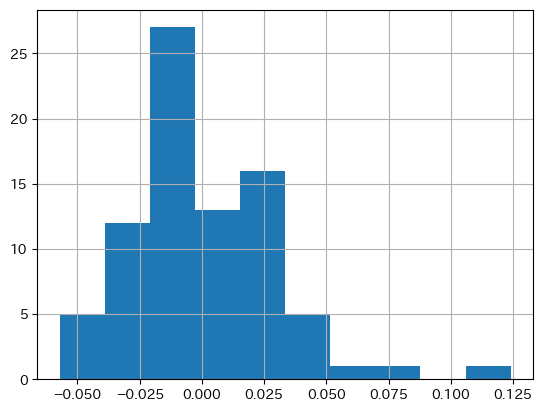

In [24]:
gas['mean_deviation'].hist()

In [25]:
cond = ( gas['price']==gas['price'].max() )
gas.loc[cond,:]

,area,price,mean_deviation
79,鹿児島市,175,0.124073


価格のばらつき具合を確認するために標準偏差を計算してみよう。

In [26]:
gas['mean_deviation'].std()

0.02861796770634357

### 結論

* 厳密な意味で一物一価の法則は成立していない。
* 理由
    * 輸送費用
    * ペン効果：所得・生産性が高い地域の価格は高い
    * `'/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/References/43773047.pdf'`
* Penn効果
    * アイスクリーム，チョコレート，ガソリンの個別にはない。
        * `'/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/No_Penn_Effect_for_Icecream.ipynb'`
    * 存在することを示す論文（クロスセクション・データ）
        * `'/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/References/43773047.pdf'`

## 経済間での一物一価

### はじめに

例としてマクドナルドのハンバーガーBig Mac（BM）を考えるが，次の変数を定義しよう。
* $P_i$：$i$国でのBMの価格
* $P_{基準}$：基準国でのBMの価格
    * 基準国は日本でもどの国でも良いが，通常，米国が使われる。その慣例に従って，$P_{基準}=P_{米}$とする。
* $e=\dfrac{i\text{国の通貨}}{米ドル}$：為替レート

一物一価が成立する場合は，次式が成り立つ。

$$
\frac{P_i}{e}=P_{米}
$$

左辺は$i$国のBM価格を為替レートを使いドル価格に変換し，右辺の米国のBM価格と等しいことを示している。

### Big Mac

The data is created using the following file 
* `'/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/PPP_ExchangeRate.ipynb'`

In [27]:
file_bigmac = '/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/source-data/ppp_bigmac.csv'
bigmac = pd.read_csv(file_bigmac)
bigmac.head()

,year,country,iso3,local_price,ppp,exr,ngdppc,rgdppc
0,2000,Argentina,ARG,2.50,0.743,1.00,7666.517834,12947.021470
1,2000,Australia,AUS,2.59,1.238,1.68,34797.776549,62634.946751
2,2000,Brazil,BRA,2.95,0.758,1.79,6817.914984,15391.109142
3,2000,Canada,CAN,2.85,1.206,1.47,36044.865154,48496.031282
4,2000,Switzerland,CHE,5.90,1.594,1.70,65635.249052,70975.564046


* `year`：年
* `country`：国名
* `iso3`：各国のiso記号
* `local_price`：ビッグマックの自国通貨表示
* `ppp`：購買力平価（「自国通貨」/米ドル）
* `exr`：為替レート（「自国通貨」/米ドル，年平均）
* `ngdppc`：名目一人当たりGDP

In [28]:
bigmac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         1137 non-null   int64  
 1   country      1137 non-null   object 
 2   iso3         1137 non-null   object 
 3   local_price  1137 non-null   float64
 4   ppp          1137 non-null   float64
 5   exr          1137 non-null   float64
 6   ngdppc       1022 non-null   float64
 7   rgdppc       1022 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 71.2+ KB


In [29]:
bigmac['year'].max()

2022

In [30]:
cond = ( bigmac['year']==2021 )
bm = bigmac.loc[cond,:].copy()
bm.head()

,year,country,iso3,local_price,ppp,exr,ngdppc,rgdppc
996,2021,United Arab Emirates,ARE,14.75,2.141,3.673150,1.627489e+05,160063.336045
997,2021,Argentina,ARG,320.00,42.953,85.373600,1.010333e+06,15045.394608
998,2021,Australia,AUS,6.48,1.498,1.299968,8.098772e+04,80987.721970
999,2021,Austria,AUT,3.88,0.755,0.823011,4.535037e+04,40773.199750
1000,2021,Azerbaijan,AZE,3.95,0.578,1.699000,9.159597e+03,3030.315898


In [31]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 996 to 1066
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         71 non-null     int64  
 1   country      71 non-null     object 
 2   iso3         71 non-null     object 
 3   local_price  71 non-null     float64
 4   ppp          71 non-null     float64
 5   exr          71 non-null     float64
 6   ngdppc       68 non-null     float64
 7   rgdppc       68 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 5.0+ KB


In [32]:
bm['iso3'].nunique()

71

### 一物一価

国内の財と同様に，次の指標を使ってBM価格の分布を考察する。

$$
BMのドル価格の平均からの乖離率=\log\left(\dfrac{P_i/e}{P_{米}}\right)
-\log\left(\overline{\dfrac{P_i/e}{P_{米}}}\right)
\tag{BMDev}
$$

* $\overline{\dfrac{P_i/e}{P_{米}}}$は$\dfrac{P_i/e}{P_{米}}$の平均
* 一物一価が成立する場合は$\dfrac{P_i/e}{P_{米}}=1$となる。

まず`local_price`と`exr`を使って，各国のBM価格をドル表示に変換する。

In [33]:
bm['dollar_price'] = bm['local_price']/bm['exr']

In [34]:
cond = ( bm['iso3']=='JPN')
bm.loc[cond,:]

,year,country,iso3,local_price,ppp,exr,ngdppc,rgdppc,dollar_price
1032,2021,Japan,JPN,390.0,96.51,104.295,4.314734e+06,4.271766e+06,3.739393


日本のBM価格390円は約3.7ドルとなっている。

In [35]:
bm['dollar_price'].describe()

count    71.000000
mean      3.912659
std       1.136833
min       1.808924
25%       3.031804
50%       3.748231
75%       4.837402
max       7.290674
Name: dollar_price, dtype: float64

最高価格は日本のBMの2倍以上の価格となっている。

In [36]:
# 米国のドル価格
cond = ( bm['iso3']=='USA')
us_dollar_price = bm.loc[cond,'dollar_price'].iloc[0]

# 米国の価格に対するi国の相対価格の対数
bm['relative_dollar_price_log'] = np.log( bm['dollar_price']/us_dollar_price )

# (BMDev)式の値
bm['price_mean_deviation'] = (
bm['relative_dollar_price_log']
    - np.log( (bm['dollar_price']/us_dollar_price).mean() )
)

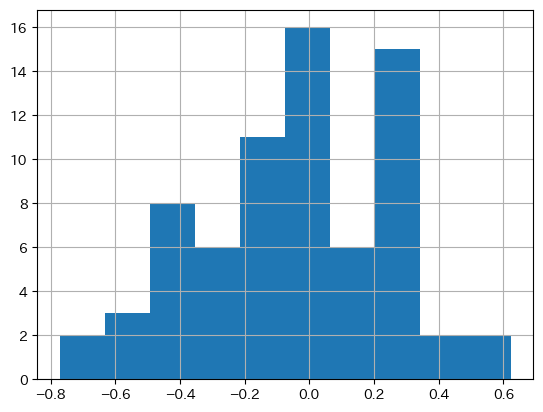

In [37]:
bm['price_mean_deviation'].hist()
pass

BM価格のばらつき具合を確認するために標準偏差を計算しよう。

In [38]:
bm['price_mean_deviation'].std()

0.2981650778621459

この値は次の式でも同じ。
$$
BMのドル価格の平均からの乖離率=\log(P_i/e)-\log\left(\overline{P_i/e}\right)
$$

* 成立しない
    * non-tradable -> no direct competition
* 国内のチョコレートなどより価格のばらつきが激しい

BM価格が最も高い５カ国

In [39]:
bm[['country','dollar_price']].sort_values('dollar_price', ascending=False).head()

,country,dollar_price
1005,Switzerland,7.290674
1058,Sweden,6.374733
1043,Norway,6.086214
1017,Finland,5.917293
1011,Germany,5.419123


BM価格が最も低い５カ国

In [40]:
bm[['country','dollar_price']].sort_values('dollar_price', ascending=False).tail()

,country,dollar_price
1000,Azerbaijan,2.324897
1062,Ukraine,2.203269
1066,South Africa,2.158158
1060,Turkey,2.006559
1053,Russia,1.808924


* 所得に影響を受けている -> Penn効果

### Penn効果

The price of development: The Penn–Balassa–Samuelson effect revisited
* `'/Users/tetsu/Documents/My_Simulation/Python/Class/Ideas/BigMacIndex/References/1-s2.0-S0022199616300873-main.pdf'`
* It is widely understood that market exchange rates do not give accurate measures of real income in different economies and that adjustment by purchasing power parity (PPP) factors is necessary for such measures. This understanding is based on an observed empirical regularity that richer countries have a higher price level than poorer countries.1 The positive correlation between cross-country price level and per-capita income is generally regarded as a stylized fact. This result was documented for twelve developed countries in the seminal paper of Bela Balassa (1964), was confirmed for a large sample of countries as soon as data from the International Comparison Program (ICP) became available and is now renowned as the Penn–Balassa–Samuelson effect (Penn–BS).2,3

* 所得が高い国・地域ほど価格が高い
* 米国の比率として考える。
    * 基準国 
    * 価格は名目だが，相対的に考えることにより「実質」価値を捉えることができる。
    * 長期的に価格は上昇トレンドにあり，相対的に考えるようが何かと便利

`EUZ`には`ngdppc`が入っていいないので，削除する。

In [41]:
bm = bm.dropna()

In [42]:
# 市場為替レートを使ってドル表示の名目GDP
bm['ngdppc_dollar_exr'] = bm['ngdppc'] / bm['exr']


# 米国の価格
cond = ( bm['iso3']=='USA' )
# 米国の名目GDP
us_ngdppc_dollar_exr = bm.loc[cond, 'ngdppc_dollar_exr'].iloc[0]


# # i国の相対的な名目GDP
bm['relative_ngdppc_dollar_exr'] = bm['ngdppc_dollar_exr'] / us_ngdppc_dollar_exr
# # i国の相対的な名目GDP（対数）
bm['relative_ngdppc_dollar_exr_log'] = np.log( bm['relative_ngdppc_dollar_exr'] )

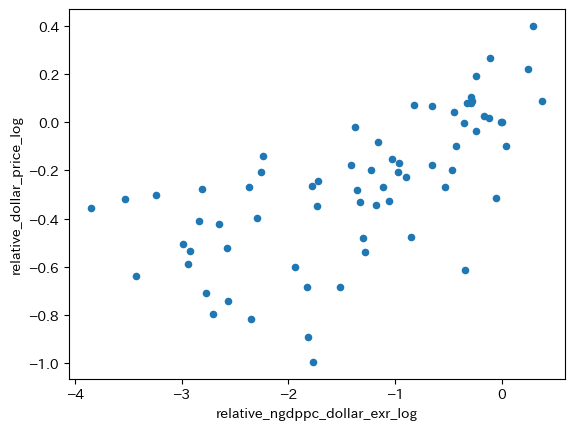

In [43]:
bm.plot('relative_ngdppc_dollar_exr_log', 
        'relative_dollar_price_log', kind='scatter')
pass

* 縦軸：$\log\left(\dfrac{P_i/e}{P_{US}}\right)$
* 横軸：$\log\left(\dfrac{i国の名目GDP(ドル)}{米国の名目GDP(ドル)}\right)$

In [44]:
bm[['relative_ngdppc_dollar_exr_log', 'relative_dollar_price_log']].corr().iloc[0,1]

0.6687456667320922

### Penn効果の分離

ここで考える問題は
> Penn効果をどのように捉えることができるだろうか。

この問に答えるために，BM価格の決定要因は次の２つから構成されると仮定しよう。

$$
\frac{P_{i}/e}{P_{米}}= D_i^{所得}\times D_i^{\text{所得以外}}\\
$$

更に，次の仮定を置く。

$$
\begin{align*}
D_i^{\text{所得}}&=e^a\left(\frac{i\text{国の所得}}{米国の所得}\right)^{b}\\
D_i^{\text{所得以外}}&=e^{u_i}
\end{align*}
$$

ここで$u_i$は国の所得以外でランダムな要素を捉える誤差項と解釈する。また，上の式の対数を取ると次式となる。

$$
p_i
= d_{i}^{所得}+d_i^{\text{所得以外}}
$$

* $p_{i}=\log\left(\dfrac{P_{i}/e}{P_{米}}\right)$
* $d_{i}^{\text{所得}}=\log\left(D_{i}^{\text{所得}}\right)
    =a+b\times\left(\dfrac{i\text{国の所得}}{米国の所得}\right)$
* $d_{i}^{\text{所得以外}}=\log\left(D_{i}^{\text{所得以外}}\right)=u_i$

これらをまとめると次式となる。

$$
p_i=a+b\times\log\left(\frac{i\text{国の所得}}{米国の所得}\right)+u_i
$$

この式をOLS推定式として推定すると，

$$
p_i=\hat{a}+\hat{b}\times\log\left(\frac{i\text{国の所得}}{米国の所得}\right)+\hat{u}_i
$$

となり，$\hat{a}$と$\hat{b}$は推定値であり，$\hat{u}_i$は残差である。

これらの結果を使い，次のように$p_i$を２つの要因にに分解することができる。

$$
p_i=
\hat{d}_i^{\text{所得}}
+\hat{d}_i^{\text{所得以外}}
$$

ここで
* $\hat{d}_i^{\text{所得}}=\hat{a}+\hat{b}\times\log\left(\dfrac{i\text{国の所得}}{米国の所得}\right)$
* $\hat{d}_i^{\text{所得以外}}=\hat{u}_i$

以下では$\hat{d}_i^{\text{所得}}$と$\hat{d}_i^{\text{所得以外}}$を計算し，それぞれの要因によって発生する価格のばらつき具合を確認することにする。

また，所得は市場為替レートを使い計算したドル表示の一人当たり名目GDPを使う。

In [45]:
res = smf.ols('relative_dollar_price_log ~ relative_ngdppc_dollar_exr_log', data=bm).fit()
res.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     relative_dollar_price_log   R-squared:                       0.447
Model:                                   OLS   Adj. R-squared:                  0.439
No. Observations:                         68   F-statistic:                     53.40
Covariance Type:                   nonrobust   Prob (F-statistic):           4.59e-10
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0179      0.043     -0.414      0.680      -0.104       0.069
relative_ngdppc_dollar_exr_log     0.1832      0.025      7.307      0.000       0.133       0.233
==================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

変数の作成

In [46]:
# パラメーターの推定値
ahat = res.params[0]
bhat = res.params[1]
# 残差
uhat = res.resid

# 所得以外の効果
bm['factor_no_income'] = np.exp( uhat )
# 所得以外の効果（対数）
bm['factor_no_income_log'] = uhat

# Penn効果
bm['factor_income'] = np.exp(ahat)*bm['relative_ngdppc_dollar_exr']**bhat
# Penn効果（対数）
bm['factor_income_log'] = ahat+bhat*bm['relative_ngdppc_dollar_exr_log']

Penn効果によるBM価格のばらつき具合をプロットする。

標準偏差：0.1997715101961256


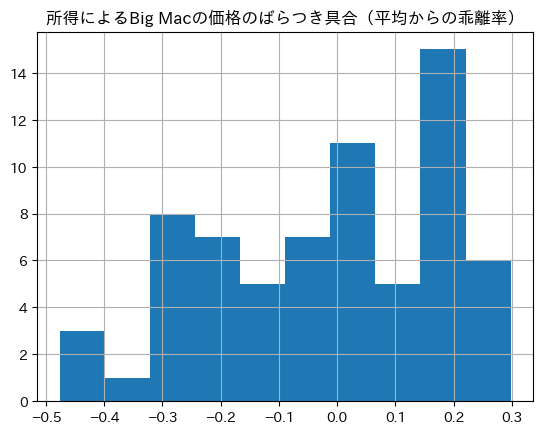

In [47]:
# Penn効果による価格の平均からの乖離率
price_mean_deviation_income = (
    bm['factor_income_log'] - np.log( bm['factor_income'].mean() )
)

# ヒストグラムのプロット
ax = price_mean_deviation_income.hist()
ax.set_title('所得によるBig Macの価格のばらつき具合（平均からの乖離率）')

# 標準偏差の表示
print(f'標準偏差：{price_mean_deviation_income.std()}')

所得以外の効果によるBM価格のばらつき具合をプロットする。

標準偏差：0.22209993494781066


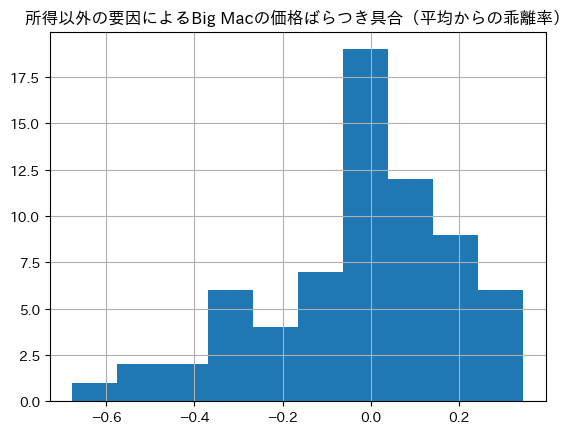

In [48]:
# 所得以外の効果による価格の平均からの乖離率
price_mean_deviation_no_income = (
    bm['factor_no_income_log'] - np.log( bm['factor_no_income'].mean() )
)

# ヒストグラムのプロット
ax = price_mean_deviation_no_income.hist()
ax.set_title('所得以外の要因によるBig Macの価格ばらつき具合（平均からの乖離率）')

# 標準偏差の表示
print(f'標準偏差：{price_mean_deviation_no_income.std()}')

所得の影響を無くすと価格の変動は小さくなっている。

### Penn効果の大きさ

ここでは次の問いを考察する。
> BMの価格の変動幅の何割がPenn効果に起因するのだろうか。

上の式を再掲する。

$$
p_i
= d_{i}^{所得}+d_i^{\text{所得以外}}
$$

この分散を次のように計算することにより，Penn効果の割合を計算することが可能となる。

$$
\begin{align*}
\text{Var}(p_i)
&=\text{Var}\left(\hat{d}_i^{\text{所得}}+\hat{d}_i^{\text{所得以外}}\right)\\
&=\text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Var}\left(\hat{d}_i^{\text{所得以外}}\right)+
    2\text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{所得以外}}\right)\\
&=\underbrace{
    \text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{所得以外}}\right)
    }_{\text{Penn効果}}+
  \underbrace{
    \text{Var}\left(\hat{d}_i^{\text{所得以外}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{所得以外}}\right)
    }_{\text{所得以外による効果}}
\end{align*}
$$

この結果を使うと（Regressionの章を参照），

$$
\begin{align*}
\left(
\begin{split}
&\text{Penn効果}\\
&\text{の割合}
\end{split}
\right)
&=\frac{
      \text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{所得以外}}\right)
    }{
    \text{Var}(p_i)}
=\frac{
    \text{Cov}\left(p_i,\hat{d}_i^{\text{所得}}\right)
    }{
    \text{Var}(p_i)}
\end{align*}
$$

$$
\begin{align*}
\left(
\begin{split}
&\text{Penn効果}\\
&\text{以外の割合}
\end{split}
\right)
&=\frac{
      \text{Var}\left(\hat{d}_i^{\text{所得以外}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{所得以外}}\right)
    }{
    \text{Var}(p_i)}
=\frac{
    \text{Cov}\left(p_i,\hat{d}_i^{\text{所得以外}}\right)
    }{
    \text{Var}(p_i)}
\end{align*}
$$

In [49]:
# Penn効果の割合
penn_bm = bm[['relative_dollar_price_log','factor_no_income_log']]
penn_bm.cov().iloc[0,1] / penn_bm.cov().iloc[0,0]

0.5527792332270497

In [50]:
# 所得以外の効果の割合
no_penn_bm = bm[['relative_dollar_price_log','factor_income_log']]
no_penn_bm.cov().iloc[0,1] / no_penn_bm.cov().iloc[0,0]

0.4472207667729503

* Penn効果が大きいことが分かる。
* BMの一物一価が成立しないのは「その他の要因」が大きな影響を及ぼしている。
    * perishable, non-tradable (extremely high transport cost)
    * Price at London does not affect much the price in Kobe

## 購買力平価

### はじめに

the rate at which the currency of one country would have to be converted into that of another country to buy the same amount of goods and services in each country.

それぞれの経済で消費される典型的な共通の財・サービスを集めて大きなバスケット（大きな籠）に入れるとしよう。それぞれの価格は各経済で異なることになり，同様にバスケットの価格も異なることになる。更に，バスケットの価格を各国の一般物価水準と考え，その相対価格を計算することにより購買力平価（PPP, Purchasing Power Parity）が算出される。

$$
\varepsilon=\frac{P_i}{P_{\text{米}}}
$$

* $P_i$：$i$国のバスケットの自国通貨価格（一般物価水準と解釈）
* $P_{\text{米}}$：米国のバスケットのドル価格（一般物価水準と解釈）

まず，次の２点について説明する。
1. 右辺の単位は「$i$国の通貨/ドル」となり，前節で考えた為替レートと同じ単位である。実際，$\varepsilon$は為替レートの一種だが，市場為替レートと異なるため特別な呼称「購買力平価」が付いている。
1. 上の式は$P_i/\varepsilon=P_{\text{米}}$と書くと一物一価の式と同じであり，違いは（1）$P$がBig Macの価格ではなく一般物価水準を表しており，（2）$e$（市場為替レート）が$\varepsilon$（PPP）になっている。このことから，PPPは次のように解釈できる。
    > $i$国と基準国のバスケットの価格（一般物価水準）が同じになる為替レート
    
    また次のようにも解釈できる。
    > 両国で同じバスケットを購入するために必要な，$i$国の貨幣と基準国の貨幣の交換率
    
    この事から，経済間のGDPなどを比較する際にPPPを使うことにより，物価水準の差をなくして純粋に経済のスケールなどを比較することが可能となる。

では，なぜ購買力平価と呼ばれるのだろうか。まず，「購買力」の部分を考えるために次式に書き換えてみる。

$$
1=\frac{P_i/\varepsilon}{P_{\text{米}}}
$$

分子の$P_i$の単位は「$i$国の通貨」であり，$\varepsilon$の単位は「ドル/$i$国の通貨」となるため，分子の単位はドルとなることが分かる（$i$国の通貨がキャンセルされる）。分母の単位はもちろんドルである。更に，次のように書き換えよう。

$$
1=\frac{1万ドル/P_{\text{米}}}{1万ドル/(P_i/\varepsilon)}
$$

分子は1万ドルで米国のバスケットをいくつ購入できるかを表しており，それが（購入できる数量で測る）購買力である。同様に，分母は1万ドルで購入できる$i$国のバスケットの数量を表す。即ち，右辺は1万ドルの米国での購買力と$i$国での購買力の割合となる。右辺が`1`より大きい（小さい）場合，1万ドルの米国での購買力はより高く（低く），より多くの（少ない）米国のバスケットを買うことができる（しかできない）。そして右辺が`1`と等しい場合，1万ドルの米国での購買力と$i$国での購買力は同じだということである。これで「平価」の部分も理解できたのではないだろうか。上の式の`1=`の部分が「平価」を表している。

以上の説明から，一物一価の法則と購買力平価が密接に関係していることは直感的に理解できるだろう。実際，一物一価は購買力平価が成立するための必要条件となる。しかし，Big Macの例が示すように一物一価は成立しない。従って，購買力平価は成立していないのが現状である。では，各国の市場為替レート（$e$）は程度購買力平価（$\varepsilon$）と比べて，どの程度高過ぎる，もしくは安過ぎるのだろうか。またPenn効果の役割はどれだけ大きいのだろうか。以下では，これらの問いを考察する。

````{note}
実質為替レート$\epsilon$は次のように定義される。
```{math}
\epsilon=\frac{P_{i}/e}{P_{\text{米}}}
```
ここで$e$は名目為替レート（$i$国の通貨/ドル）である。この式から次のことが分かる。購買力平価が成立する場合，$e=\varepsilon$且つ$\epsilon=1$となり，実質為替レートは`1`となる。
````

### PPP

World Development Indicators
* PPPと名目為替レートのパネルデータを入手
* 2021年の各国の乖離率を計算（cross section）
* 日本の乖離率の表示 (time series)
* absolute vs relative PPP

### 時系列

* End-of-period exchange rate -> volatile
* Ideally, period average would be better

#### 絶対的PPP

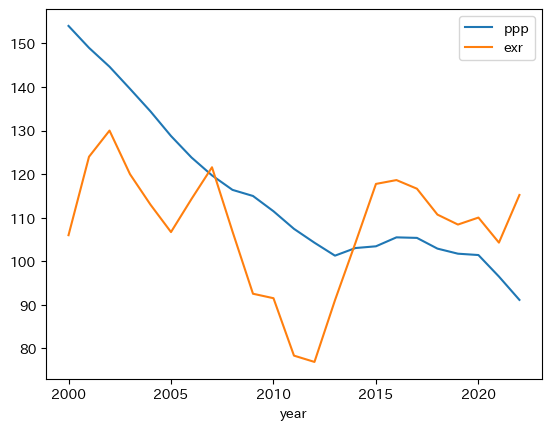

In [51]:
cond = ( bigmac['iso3']=='JPN')
jpn = bigmac.loc[cond,:].copy()
jpn.plot('year',['ppp','exr'])
pass

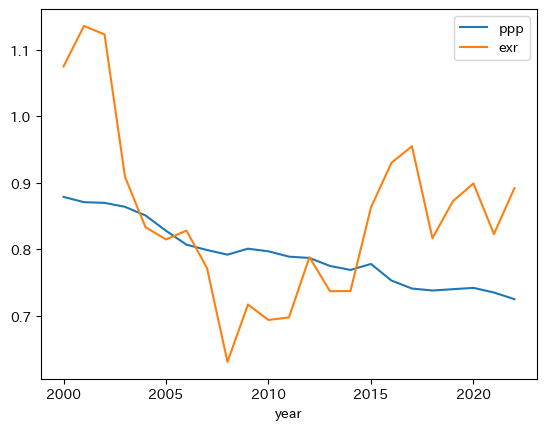

In [52]:
cond = ( bigmac['iso3']=='EUZ')
euz = bigmac.loc[cond,:].copy()
euz.plot('year',['ppp','exr'])
pass

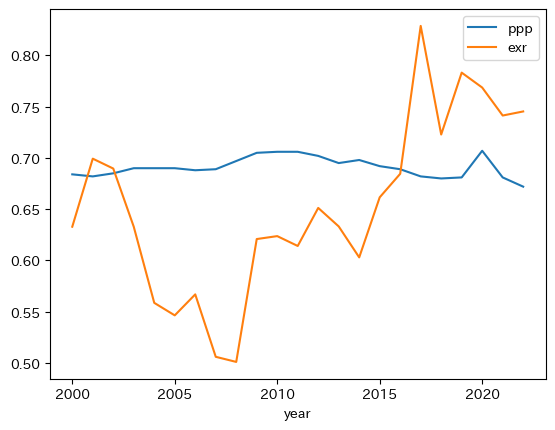

In [53]:
cond = ( bigmac['iso3']=='GBR')
gbr = bigmac.loc[cond,:].copy()
gbr.plot('year',['ppp','exr'])
pass

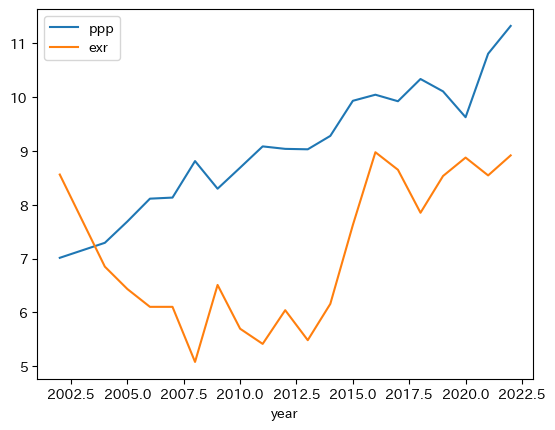

In [54]:
cond = ( bigmac['iso3']=='NOR')
nor = bigmac.loc[cond,:].copy()
nor.plot('year',['ppp','exr'])
pass

#### 相対的PPP

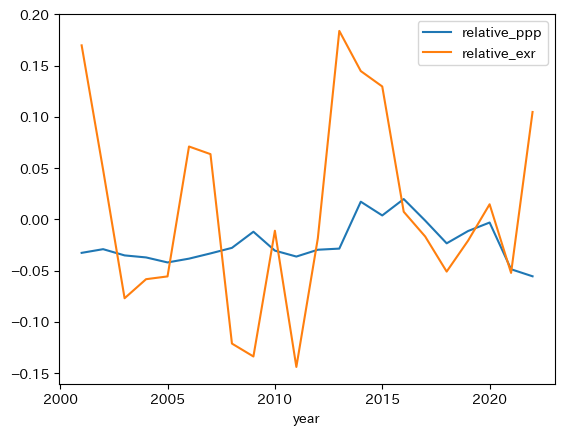

In [55]:
jpn['relative_ppp'] = jpn['ppp'].pct_change()
jpn['relative_exr'] = jpn['exr'].pct_change()
jpn.plot('year',['relative_ppp','relative_exr'])
pass

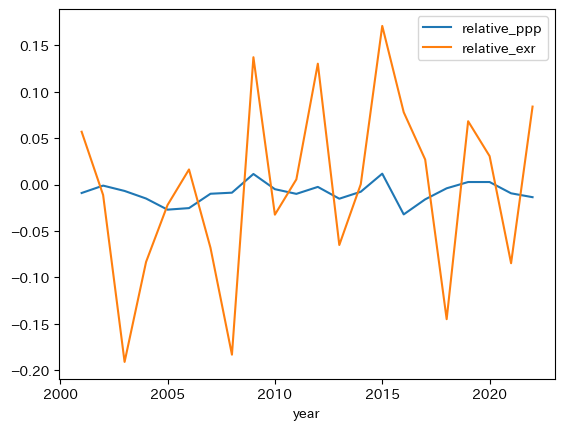

In [56]:
euz['relative_ppp'] = euz['ppp'].pct_change()
euz['relative_exr'] = euz['exr'].pct_change()
euz.plot('year',['relative_ppp','relative_exr'])
pass

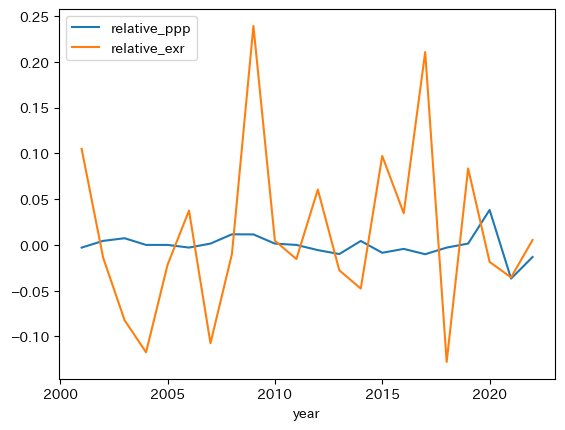

In [57]:
gbr['relative_ppp'] = gbr['ppp'].pct_change()
gbr['relative_exr'] = gbr['exr'].pct_change()
gbr.plot('year',['relative_ppp','relative_exr'])
pass

### ドル表示のバスケットの相対価格

$$
\text{ppp}=\frac{P_i}{P_{US}}
=\frac{i国のバスケットのi国貨幣価格}{米国のバスケットのドル価格}
$$

$$
\text{exr}=\frac{i国の通貨}{米ドル}
$$

$$
\frac{P_i/\text{exr}}{P_{US}}=\frac{ppp}{exr}
=\frac{i国のバスケットのドル価格}{米国のバスケットのドル価格}
$$

まず，ドル表示の相対価格（実質為替レートと同じ）のヒストグラム

In [58]:
# ドル表示の相対価格（実質為替レートと同じ）
bm['ppp_exr_log'] = np.log( bm['ppp']/bm['exr'] )

米国は`0`になり既に標準化されている。

標準偏差 0.41700710077330566


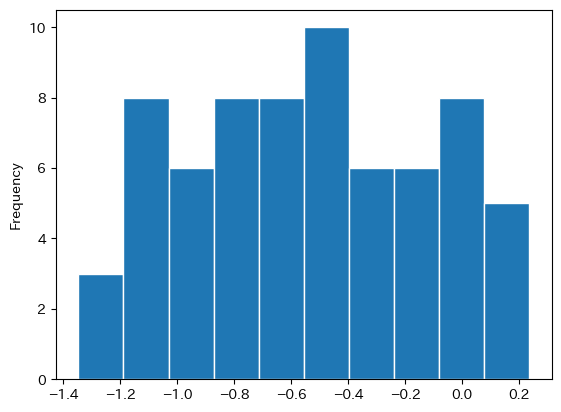

In [59]:
bm['ppp_exr_log'].plot(kind='hist', ec='white')
print('標準偏差',bm['ppp_exr_log'].std())

PPPが成立している場合は`0`に集まる。

* `0`より大きい場合：
    * その国の貨幣は米ドルに対してovervalued
* `0`より小さい場合：
    * その国の貨幣は米ドルに対してundervalued

<StemContainer object of 3 artists>

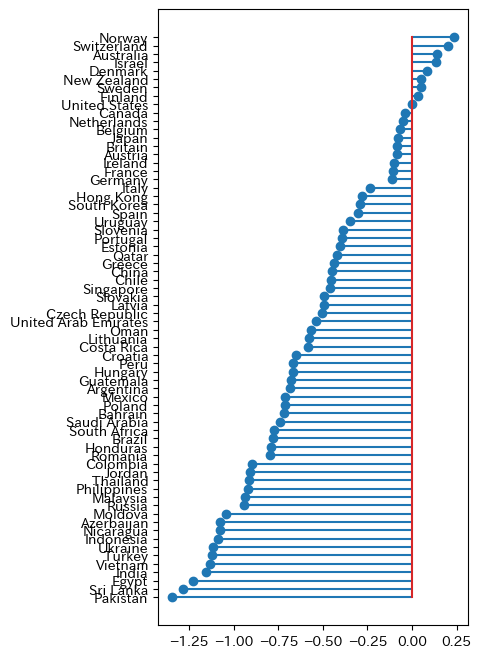

In [60]:
fig, ax = plt.subplots(figsize=(4,8))
ax.stem('country', 'ppp_exr_log', 
        data=bm.sort_values('ppp_exr_log'),
        orientation='horizontal')

所得が低い経済のバスケットの価格が低い傾向にある。

### Penn効果

BMの分析では市場為替レートで計算した名目GDPを使った。ここではPPPで計算した名目GDPを使う。理由：
* 市場為替レート計算した名目GDPは，経済間の価格の差を残したままのGDPとなる。その価格差はPenn効果を表しており，それを残したままのGDPとなってします。
* 価格に対する所得の純粋な効果（相関）を調べるためには，価格差が生じる「不純物」を取り除く必要がある。それにより，所得と価格の「浄化された」相関関係を計算することができる。


In [61]:
# PPPを使ってドル表示の名目GDP
bm['ngdppc_dollar_ppp'] = bm['ngdppc'] / bm['ppp']


# 米国の価格
cond = ( bm['iso3']=='USA' )
# 米国のGDP
us_ngdppc_dollar_ppp = bm.loc[cond, 'ngdppc_dollar_ppp'].iloc[0]


# i国の相対的なGDP
bm['relative_ngdppc_dollar_ppp'] = bm['ngdppc_dollar_ppp'] / us_ngdppc_dollar_ppp
# i国の相対的なGDP（対数）
bm['relative_ngdppc_dollar_ppp_log'] = np.log( bm['relative_ngdppc_dollar_ppp'] )

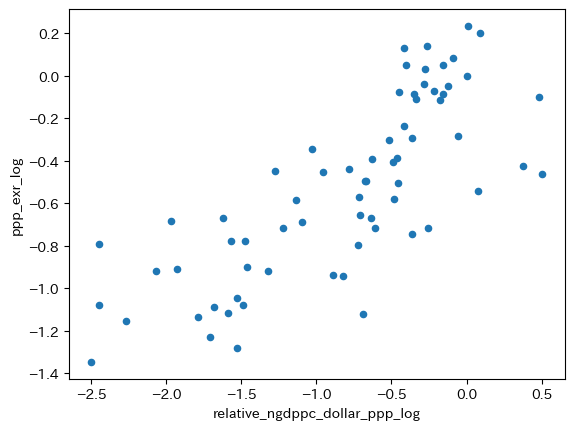

In [62]:
bm.plot('relative_ngdppc_dollar_ppp_log', 'ppp_exr_log', kind='scatter')
pass

In [63]:
res_ngdppc = smf.ols('ppp_exr_log ~ relative_ngdppc_dollar_ppp_log', data=bm).fit()
res_ngdppc.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ppp_exr_log   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.584
No. Observations:                  68   F-statistic:                     95.16
Covariance Type:            nonrobust   Prob (F-statistic):           2.02e-14
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.1736      0.049     -3.547      0.001      -0.271      -0.076
relative_ngdppc_dollar_ppp_log     0.4348      0.045      9.755      0.000       0.346       0.524
==================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# パラメーターの推定値
ahat = res_ngdppc.params[0]
bhat = res_ngdppc.params[1]
# 残差
uhat = res_ngdppc.resid

# 所得以外の効果
bm['ngdppc_factor_no_income'] = np.exp( uhat )
# 所得以外の効果（対数）
bm['ngdppc_factor_no_income_log'] = uhat

# Penn効果
bm['ngdppc_factor_income'] = np.exp(ahat)*bm['relative_ngdppc_dollar_ppp']**bhat
# Penn効果（対数）
bm['ngdppc_factor_income_log'] = ahat+bhat*bm['relative_ngdppc_dollar_ppp_log']

Penn効果によるバスケットの価格のばらつき具合をプロットする。

標準偏差：0.3204377018087325


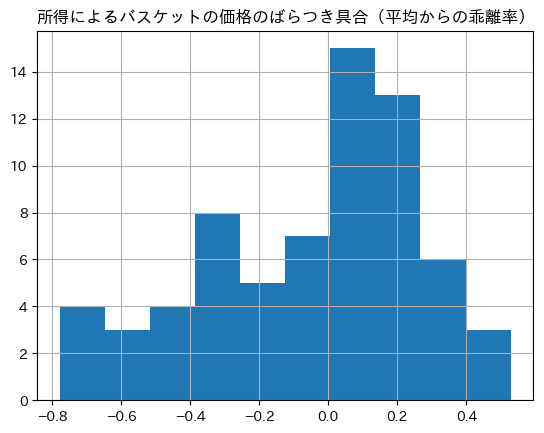

In [65]:
# Penn効果による価格の平均からの乖離率
ngdppc_mean_deviation_income = (
    bm['ngdppc_factor_income_log']
    - np.log( bm['ngdppc_factor_income'].mean() )
)

# ヒストグラムのプロット
ax = ngdppc_mean_deviation_income.hist()
ax.set_title('所得によるバスケットの価格のばらつき具合（平均からの乖離率）')

# 標準偏差の表示
print(f'標準偏差：{ngdppc_mean_deviation_income.std()}')

所得以外の効果によるバスケットの価格のばらつき具合をプロットする。

標準偏差：0.2668606403254248


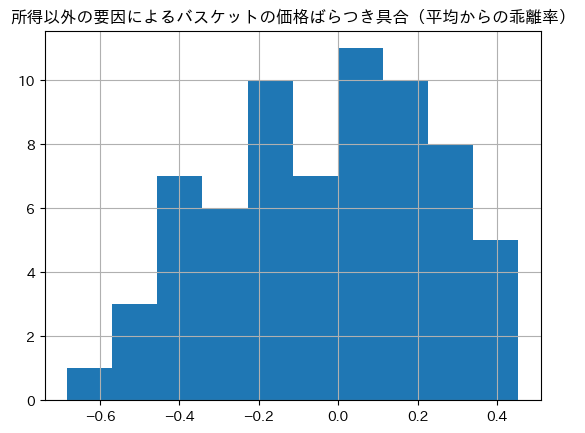

In [66]:
# 所得以外の効果による価格の平均からの乖離率
ngdppc_mean_deviation_no_income = (
    bm['ngdppc_factor_no_income_log']
    - np.log( bm['ngdppc_factor_no_income'].mean() )
)

# ヒストグラムのプロット
ax = ngdppc_mean_deviation_no_income.hist()
ax.set_title('所得以外の要因によるバスケットの価格ばらつき具合（平均からの乖離率）')

# 標準偏差の表示
print(f'標準偏差：{ngdppc_mean_deviation_no_income.std()}')

所得の影響を無くすと価格の変動は小さくなっている。

### Penn効果の大きさ

ここでは次の問いを考察する。
> BMの価格の変動幅の何割がPenn効果に起因するのだろうか。

再掲

$$
\begin{align*}
\left(
\begin{split}
&\text{Penn効果}\\
&\text{の割合}
\end{split}
\right)
&=\frac{
    \text{Cov}\left(p_i,\hat{d}_i^{\text{所得}}\right)
    }{
    \text{Var}(p_i)}
\end{align*}
$$

$$
\begin{align*}
\left(
\begin{split}
&\text{所得以外による}\\
&\text{効果の割合}
\end{split}
\right)
&=\frac{
    \text{Cov}\left(p_i,\hat{d}_i^{\text{所得以外}}\right)
    }{
    \text{Var}(p_i)}
\end{align*}
$$

In [67]:
# Penn効果の割合
penn_ppp_exr = bm[['ppp_exr_log','ngdppc_factor_income_log']]
penn_ppp_exr.cov().iloc[0,1] / penn_ppp_exr.cov().iloc[0,0]

0.590473370373379

In [68]:
# 所得以外の効果の割合
no_penn_ppp_exr = bm[['ppp_exr_log','ngdppc_factor_no_income_log']]
no_penn_ppp_exr.cov().iloc[0,1] / no_penn_ppp_exr.cov().iloc[0,0]

0.4095266296266209

BMの一物一価が成立しないのは「その他の要因」が大きな影響を及ぼしている。
* perishable, non-tradable (extremely high transport cost)
    * Price at London does not affect much the price in Kobe

### Penn効果の含意

市場為替レートで算出するとPenn効果が発生する。
* 所得が高い経済の価格は高く，所得が低い経済の価格は低い
* バスケットの価格差がある

市場為替レートによる影響
* 所得が高い経済のGDPは高く産出され，所得が低い経済の価格は低く算出される。
* 所得格差の大きさが大きく算出される

PPP
* バスケットの価格差をなくす

含意：
* PPPを使った場合と比べて，市場為替レートを使うと経済格差が過大となる。

In [69]:
bm['ngdppc_dollar_exr_log'] = np.log( bm['ngdppc_dollar_exr'] )
bm['ngdppc_dollar_ppp_log'] = np.log( bm['ngdppc_dollar_ppp'] )

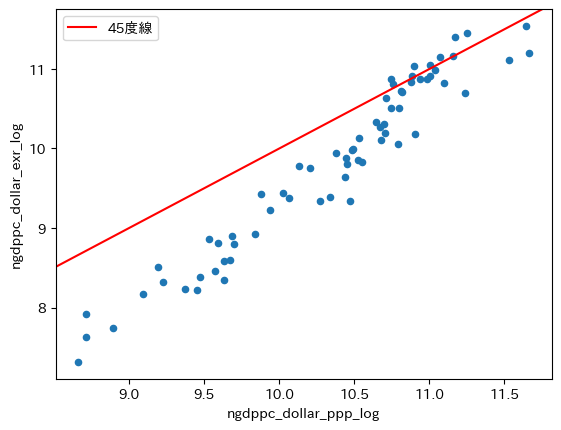

In [70]:
ax = bm.plot('ngdppc_dollar_ppp_log','ngdppc_dollar_exr_log', kind='scatter')
ax.axline((9, 9), (10, 10), color='red', label='45度線')
ax.legend()

* USA is on the 45 degree line
* Countries above the 45 degree line
    * `ppp`と比較して`exr`のGDPは大きくなっている。
    * 所得が高いGDPは`exr`のGDPは`ppp`より大きくなっている
* Countries below the 45 degree line
    * `ppp`と比較して`exr`のGDPは小さくなっている。
    * 所得が低いGDPは`exr`のGDPは`ppp`より小さくなっている
    
＜含意＞
* `ppp`と比較して`exr`で評価すると一人当たりGDPで測る経済格差は過大評価される

変動係数

In [71]:
bm['ngdppc_dollar_ppp_log'].std() / bm['ngdppc_dollar_ppp_log'].mean()

0.07126858411370322

In [72]:
bm['ngdppc_dollar_exr_log'].std() / bm['ngdppc_dollar_exr_log'].mean()

0.11115498857747703

最大値と最小値の比率

In [73]:
bm['ngdppc_dollar_ppp_log'].max() / bm['ngdppc_dollar_ppp_log'].min()

1.3467308637999993

In [74]:
bm['ngdppc_dollar_exr_log'].max() / bm['ngdppc_dollar_exr_log'].min()

1.577650073926438

`ngdppc`ランキング

In [75]:
bm.sort_values('ngdppc_dollar_ppp_log', ascending=False)[['country']].head(10)

,country
1055,Singapore
1028,Ireland
1051,Qatar
1005,Switzerland
996,United Arab Emirates
1043,Norway
1064,United States
1022,Hong Kong
1012,Denmark
1042,Netherlands


In [76]:
bm.sort_values('ngdppc_dollar_exr_log', ascending=False)[['country']].head(10)

,country
1028,Ireland
1005,Switzerland
1043,Norway
1055,Singapore
1064,United States
1012,Denmark
1051,Qatar
1058,Sweden
998,Australia
1042,Netherlands


Text(0.5, 1.0, '1人当たり名目GDP\n（対数, 米ドル，2021年）')

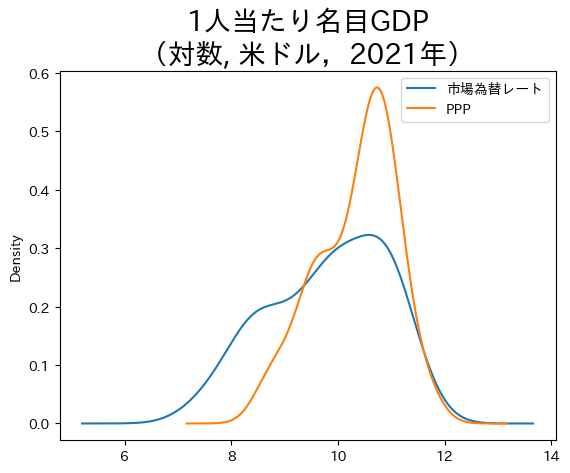

In [77]:
ax = bm[['ngdppc_dollar_exr_log','ngdppc_dollar_ppp_log']].plot(kind='kde')
ax.legend(['市場為替レート','PPP'])
ax.set_title('1人当たり名目GDP\n（対数, 米ドル，2021年）', size=20)

＜Poverty＞
* https://datatopics.worldbank.org/world-development-indicators/stories/adjusting-for-price-differences-across-the-world.html

WBが使っている貧困線：1日1.9米ドル

* 市場為替レートで計算（2021年）
    * 1.9米ドル　＊　109.6（ケニアシリング/米ドル）＝　208.24（ケニアシリング）
* PPP（2021年）
    * 1.9米ドル　＊　43.722（ケニアシリング/米ドル）＝　83.0718（ケニアシリング）
    
PPPを使って計算している。

### Big Mac Index (Again)

BMの自国通貨価格に市場為替レートとPPPを使った場合のドル価格のばらつき具合をプロットしてみよう。

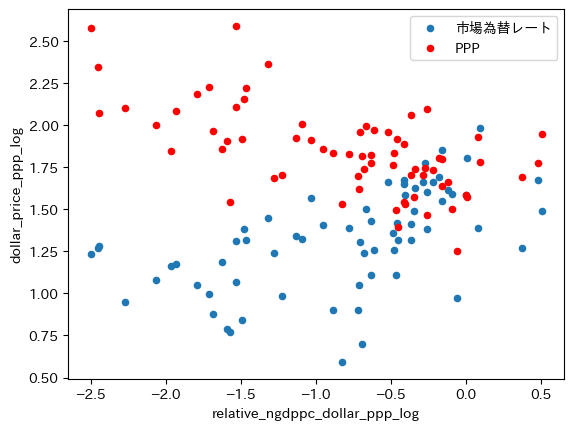

In [78]:
bm['dollar_price_exr_log'] = np.log( bm['local_price'] / bm['exr'] )
bm['dollar_price_ppp_log'] = np.log( bm['local_price'] / bm['ppp'] )

ax = bm.plot('relative_ngdppc_dollar_ppp_log',
             'dollar_price_exr_log', kind='scatter',
             label='市場為替レート')
bm.plot('relative_ngdppc_dollar_ppp_log',
        'dollar_price_ppp_log', kind='scatter', ax=ax,
        color='red', label='PPP')
ax.legend()
pass

* 市場為替レートの場合，所得が増えると価格も上昇するPenn効果が現れている。
* PPPの場合，右下がりとなっている。所得が低いと価格が高い。
    * 考えられる理由：MBは非貿易財である。また労働集約型であり飲食サービス業である。
    * 所得が低い国ではサービスは奢侈品（しゃし）贅沢財と解釈できる。
    * 例：MacDonalds in India is food only for the upper caste